In [1]:
import os, sys
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.models import LightGBMModel, XGBModel, LinearRegressionModel, TFTModel, TransformerModel
from darts.metrics import mase, mse, rmse, mae
from darts.dataprocessing.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler   
from darts.dataprocessing.transformers.scaler import Scaler
from darts.utils.missing_values import extract_subseries

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
from wandb.xgboost import WandbCallback

import wandb
wandb.login()


import warnings
warnings.filterwarnings('ignore')

# Set seed
np.random.seed(42)

# Set working directory
os.chdir(r"..") # should be the git repo root directory
print("Current working directory: " + os.getcwd())
repo_name = 'net-load-forecasting'
assert os.getcwd()[-len(repo_name):] == "net-load-forecasting", "Working directory is not the git repo root directory"


from utils.utils import *

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\net-load-forecasting


In [2]:
clean_data_path = os.path.join(os.getcwd(),'data','clean_data')
model_data_path = os.path.join(os.getcwd(),'data','model_data')

In [210]:

def load_data(config):

    '''

    Function to load the data for the different model setups.

    Parameters
    ----------
    config : Config
        Config object with the model setup parameters.

    Returns
    -------
    data : dict
        Dictionary with the data for a specific model setup.


    '''

    df = pd.read_hdf(os.path.join(clean_data_path, "data_net_load_forecasting.h5"), key=f"{config.temp_resolution}min/netload") / 1e3
    df_irr = pd.read_hdf(os.path.join(clean_data_path, "data_net_load_forecasting.h5"), key=f"{config.temp_resolution}min/weather")
    df_irr.rename({'temperature': 'temp_air'}, axis=1, inplace=True)
    df_pv_forecast = pd.read_hdf(os.path.join(model_data_path, "pv_model_results.h5"), key=f"{config.temp_resolution}min/pv_forecast_META-{config.META}") / 1e3

    train_end = int(config.train_ratio * len(df))
    val_begin = int(config.val_ratio* len(df))


    df_train_int = df[:train_end]
    df_val_int = df[-val_begin:]
    df_test_int = df[-val_begin:]

    df_cov_dir_train = df_irr[:train_end]
    df_cov_dir_val = df_irr[-val_begin:]
    df_cov_dir_test = df_irr[-val_begin:]

    df_cov_pv_train = df_pv_forecast[:train_end]
    df_cov_pv_val = df_pv_forecast[-val_begin:]
    df_cov_pv_test = df_pv_forecast[-val_begin:]

    df_train_add = df_train_int + df_cov_pv_train.values
    df_train_add[df_train_add < 0] = 0
    df_val_add = df_val_int + df_cov_pv_val.values
    df_val_add[df_val_add < 0] = 0
    df_test_add = df_test_int + df_cov_pv_test.values
    df_test_add[df_test_add < 0] = 0

    # In this study we are comparing three different model setups: integrated, additive and direct for net load forecasting
    model_setups = {
                    'integrated': {'target': (df_train_int, df_val_int, df_test_int), 'covs': (df_cov_pv_train, df_cov_pv_val, df_cov_pv_test)},
                    'additive': {'target': (df_train_add, df_val_add, df_test_add), 'covs': (None, None, None)},
                    'direct': {'target': (df_train_int, df_val_int, df_test_int), 'covs': (df_cov_dir_train, df_cov_dir_val, df_cov_dir_test)}
                    }


    return model_setups


def darts_data_pipeline(config, model_setups):

    '''

    Function to transform the data into darts.TimeSeries format and apply the data pipeline.

    Parameters
    ----------
    config : Config

    data : dict
        Dictionary with the data for the different model setups.

    Returns
    -------
    piped_data : dict
        Dictionary with the transformed data for the different model setups.

    pipeline : darts.dataprocessing.pipeline.Pipeline
        Pipeline object with the data pipeline.


    '''

    
    data = model_setups[config.model_setup]

    df_train, df_val, df_test = data['target']
    df_cov_train, df_cov_val, df_cov_test = data['covs']
    

    # Into Darts format
    ts_train = darts.TimeSeries.from_dataframe(df_train, freq=str(config.temp_resolution) + 'min')
    ts_train = extract_subseries(ts_train)
    ts_val = darts.TimeSeries.from_dataframe(df_val, freq=str(config.temp_resolution) + 'min')
    ts_val = extract_subseries(ts_val)
    ts_test = darts.TimeSeries.from_dataframe(df_test, freq=str(config.temp_resolution) + 'min')
    ts_test = extract_subseries(ts_test)

    if config.model_setup == 'additive':
        ts_cov_train = None
        ts_cov_val = None
        ts_cov_test = None
    else:
        ts_cov_train = darts.TimeSeries.from_dataframe(df_cov_train, freq=str(config.temp_resolution) + 'min')
        ts_cov_val = darts.TimeSeries.from_dataframe(df_cov_val, freq=str(config.temp_resolution) + 'min')
        ts_cov_test = darts.TimeSeries.from_dataframe(df_cov_test, freq=str(config.temp_resolution) + 'min')

    # Reviewing subseries to make sure they are long enough

    min_len = config.n_lags + config.n_ahead

    ts_train_, ts_cov_train = review_subseries(ts_train, min_len, ts_cov_train)
    ts_val_, ts_cov_val = review_subseries(ts_val,  min_len, ts_cov_val)
    ts_test_, ts_cov_test = review_subseries(ts_test, min_len, ts_cov_test)



    # Load pipeline
    pipeline = Pipeline( # missing values have been filled in the 'data_prep.ipynb'
                        [
                        Scaler(MinMaxScaler()),
                        ]
                        )
    
    ts_train_piped = pipeline.fit_transform(ts_train_)
    ts_val_piped = pipeline.transform(ts_val_)
    ts_test_piped = pipeline.transform(ts_test_)

    if config.model_setup == 'additive':
        ts_cov_train_piped = None
        ts_cov_val_piped = None
        ts_cov_test_piped = None

    else:  
        # Future Covariate Pipeline
        pipeline_weather = Pipeline([Scaler(MinMaxScaler())])
        ts_cov_train_piped = pipeline_weather.fit_transform(ts_cov_train)
        ts_cov_val_piped = pipeline_weather.transform(ts_cov_val)
        ts_cov_test_piped = pipeline_weather.transform(ts_cov_test)

    # getting the index of the longest subseries, to be used for evaluation later
    longest_ts_val_idx = get_longest_subseries_idx(ts_val_piped)
    longest_ts_test_idx = get_longest_subseries_idx(ts_test_piped)


    piped_data = {'target': (ts_train_piped, ts_val_piped[longest_ts_val_idx], ts_test_piped[longest_ts_test_idx]),
                'covs': (ts_cov_train_piped, ts_cov_val_piped, ts_cov_test_piped),
                'target_inversed': (ts_train, ts_val[longest_ts_val_idx], ts_test[longest_ts_test_idx])}

    return piped_data, pipeline


def train_all(config_run):

    config = build_config(config_run)
    
    if config.wandb:
        wandb.init(project="net-load-forecasting", name=f"META-{config.META}_METER-{config.METER}-train_ratio-{config.train_ratio}")
        wandb.config.update(config.data)

    predictions_per_model = {}
    model_setups_names = config.model_setups_names
    eval_set_idx = {'train': 0, 'val': 1, 'test': 2}
    for model_setup in model_setups_names:

        print(f'Running model setup: {model_setup}')
        config.model_setup = model_setup


        model_setups_data = load_data(config)
        piped_data, pipeline = darts_data_pipeline(config, model_setups_data)
        ts_train_piped, ts_val_piped, ts_test_piped = piped_data['target']
        ts_cov_train_piped, ts_cov_val_piped, ts_cov_test_piped = piped_data['covs']
        trg_train_inversed, trg_val_inversed, trg_test_inversed = piped_data['target_inversed']


        print('Training model')
        # TODO: replace with patch transformer
        model = LightGBMModel(lags=config.n_lags,
                        lags_future_covariates= None if config.model_setup == 'additive' else [0],
                        add_encoders=config.datetime_encoding   , 
                        output_chunk_length=config.n_ahead, 
                        likelihood=None,
                        random_state=42
                        )

        model.fit(ts_train_piped, future_covariates = ts_cov_train_piped)

        print('Evaluating on validation set')
        predictions, _ = predict_testset(config, model, 
                                        ts_val_piped, 
                                        ts_cov_val_piped,
                                        pipeline,
                                        )
        
            # subtracting the covariates from the predictions, since we are predicting the net load
        if config.model_setup == 'additive':
            predictions -= model_setups_data['integrated']['covs'][eval_set_idx[config.evaluation_set]].reindex(predictions.index).values

        predictions.columns = ['prediction_'+model_setup]
        predictions_per_model[model_setup] = predictions
        
    if config.evaluation_set == 'val':
        persistance = trg_val_inversed.pd_dataframe().shift(config.timesteps_per_hour * 24)
    else:
        persistance = trg_test_inversed.pd_dataframe().shift(config.timesteps_per_hour * 24)

    persistance.columns = ['24h_persistance']
    predictions_per_model['24h_persistance'] = persistance


    df_metrics = format_and_log_predictions(config, predictions_per_model, trg_val_inversed, trg_test_inversed)

    if config.wandb:
        wandb.finish()

    return df_metrics


def format_and_log_predictions(config, predictions_per_model, trg_val_inversed, trg_test_inversed):

    '''
    Evaluates the predictions on the validation set using the evaluation metrics specified in the config.

    Parameters
    ----------
    df_compare : pandas.DataFrame
        DataFrame with the predictions and the ground truth values.
    config : Config
        Config object with the model setup parameters.

    Returns
    -------
    df_metrics : pandas.DataFrame
        DataFrame with the evaluation metrics for each model.


    '''

    if config.evaluation_set == 'val':
        df_predictions = pd.concat(predictions_per_model.values(), axis=1)
        df_compare = pd.merge(trg_val_inversed.pd_dataframe(), df_predictions, left_index=True, right_index=True)
    else:
        df_predictions = pd.concat(predictions_per_model.values(), axis=1)
        df_compare = pd.merge(trg_test_inversed.pd_dataframe(), df_predictions, left_index=True, right_index=True)


    fig = px.line(df_compare, x=df_compare.index, y=df_compare.columns)

    fig.update_layout(
        title=f"Predictions for {config.evaluation_set} set",
        xaxis_title="Time",
        yaxis_title="Net Load [kW]",
        legend_title="Legend Title"

    )

    if config.wandb: 
        wandb.log({"predictions": fig})
    else:
        fig.show()
    

    #Metrics for each model
    df_gt = df_compare.iloc[:,[0]]
    ts_gt = darts.TimeSeries.from_dataframe(df_gt)
    df_metrics = pd.DataFrame(index = df_compare.columns[1:], columns = [metric.__name__ for metric in config.eval_metrics])
    for col in df_compare.columns[1:]:
        ts_pred = darts.TimeSeries.from_dataframe(df_compare[[col]])
        for metric in config.eval_metrics:
            df_metrics.loc[col, metric.__name__] = metric(ts_gt, ts_pred)

    # persistance skill score
    rmse_persistence = df_metrics.loc[df_metrics.index == '24h_persistance', 'rmse'][0]
    df_metrics['rmse_skill'] = 1 - df_metrics['rmse'] / rmse_persistence
    
    # imbalance costs
    df_imbalance = pd.read_hdf(os.path.join(clean_data_path, "data_net_load_forecasting.h5"), key="imbalance_price")
    df_compare_energy = df_compare.copy() * (1/config.timesteps_per_hour)
    df_metrics['imbalance_costs'] = np.nan
    df_gt = df_compare_energy.iloc[:,[0]]
    for col in df_compare_energy.columns[1:]:
        df_pred = df_compare_energy[[col]]
        df_costs = calc_imbalance_costs(df_imbalance, df_gt, df_pred, unit='kWh')
        df_metrics.loc[col, 'imbalance_costs'] = df_costs.sum()[0]



    if config.wandb:
        wandb.log({"metrics": wandb.Table(dataframe=df_metrics.reset_index())})

    return df_metrics


def build_config(config_dataset):

    '''
    
    Takes a config_dataset dictionary and builds a config object from it, deriving the rest of the parameters from the config_dataset.

    '''

    config = Config().from_dict(config_dataset)
    config.temp_resolution =  15 #  1 if config.METER == '1' else #(in minutes)
    config.horizon_in_hours = 24 + 36 if config.METER == '2' else 36 # in hours, 24 for the data gap in METER-2 and 36 for the day-ahead forecast horizon
    config.timestep_encoding = ["hour", "minute"] if config.temp_resolution == 1 else ['quarter']
    config.datetime_encoding =  {
                        "cyclic": {"future": config.timestep_encoding, 'past': config.timestep_encoding}, 
                        "position": {"future": ["relative",], 'past': ["relative",]},
                        "datetime_attribute": {"future": ["dayofweek", "week"], 'past': ["dayofweek", "week"]},
                } if config.use_datetime_encoding else None

    config.timesteps_per_hour = int(60 / config.temp_resolution)
    config.n_lags = config.lookback_in_hours * config.timesteps_per_hour
    config.n_ahead = config.horizon_in_hours * config.timesteps_per_hour
    config.eval_stride = int(np.sqrt(config.n_ahead)) # evaluation stride, how often to evaluate the model, in this case we evaluate every n_ahead steps
    
    return config


In [211]:
def calc_imbalance_costs(df_imbalance_price, df_gt, df_pred, unit='MWh'):

    '''

    Calculates the imbalance costs for a given prediction and ground truth.
    First convert power to energy, then multiply by the imbalance price.
    

    Parameters
    ----------
    df_imbalance_price : pandas.DataFrame
        DataFrame with the imbalance prices.
    df_gt : pandas.DataFrame

    df_pred : pandas.DataFrame

    Returns
    -------
    df_costs : pandas.DataFrame
        DataFrame with the imbalance costs for each prediction.

    '''

    unit_dict = {'MWh': 1, 'kWh': 1000, 'Wh': 1000000}

    df_comp = pd.merge(df_gt, df_pred, left_index=True, right_index=True, how='inner').dropna()
    df_error = (df_comp.iloc[:,0] - df_comp.iloc[:,1]).to_frame('Diff')
    df_imbalance_price = df_imbalance_price.reindex(df_error.index)
    

    df_costs = pd.DataFrame(index=df_imbalance_price.index)
    for row in df_imbalance_price.index:
        # Regulation state 1
        if df_imbalance_price.loc[row, 'Regulation state']==1:
        # For GNN
            if df_error.loc[row,'Diff']>=0:
                if df_imbalance_price.loc[row,'Feed']>=0:
                    df_costs.loc[row,'Costs']=df_error.loc[row,'Diff']*df_imbalance_price.loc[row,'Feed']
                else:
                    df_costs.loc[row,'Costs']=df_error.loc[row,'Diff']*df_imbalance_price.loc[row,'Feed']
            else:
                if df_imbalance_price.loc[row,'Consume']>=0:
                    df_costs.loc[row,'Costs']=(-1)*df_error.loc[row,'Diff']*df_imbalance_price.loc[row,'Consume']
                else:
                    df_costs.loc[row,'Costs']=(-1)*df_error.loc[row,'Diff']*df_imbalance_price.loc[row,'Consume']
        # Regulation state -1
        elif df_imbalance_price.loc[row, 'Regulation state']==-1:
            # For GNN
            if df_error.loc[row,'Diff']>=0:
                if df_imbalance_price.loc[row,'Feed']>=0:
                    df_costs.loc[row,'Costs']=df_error.loc[row,'Diff']*df_imbalance_price.loc[row,'Feed']
                else:
                    df_costs.loc[row,'Costs']=df_error.loc[row,'Diff']*df_imbalance_price.loc[row,'Feed']
            else:
                if df_imbalance_price.loc[row,'Consume']>=0:
                    df_costs.loc[row,'Costs']=(-1)*df_error.loc[row,'Diff']*df_imbalance_price.loc[row,'Consume']
                else:
                    df_costs.loc[row,'Costs']=(-1)*df_error.loc[row,'Diff']*df_imbalance_price.loc[row,'Consume']
    
    return df_costs / unit_dict[unit]

### Train a single model

In [212]:


config_run = {
'model_setups_names': [
                             'additive',
                             'integrated',
                            'direct'
                        ],
'model_setup': None,
'METER': '1',
'META': '1',
'train_ratio': 0.8,
'val_ratio': 0.1,
'lookback_in_hours' : 24,
'path_len': 4,
'liklihood': None,
'holiday': True,
'use_datetime_encoding': True,
'boxcox': False,
'eval_metrics' : [mae, mse, rmse],
'evaluation_set': 'val',
'wandb': False,
}

df_metrics, df_compare = train_all(config_run)



Running model setup: additive
Training model


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Evaluating on validation set
Running model setup: integrated


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.


Training model
Evaluating on validation set
Running model setup: direct


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.


Training model
Evaluating on validation set


ValueError: too many values to unpack (expected 2)

### Iterating through all model setups and METER Scenarios

In [ ]:

scores_dict_meter = {}
ratios = [0.3, 0.4,0.6,0.7, 0.9]


for METER in ['1','2']:

    scores_dict_train_ratio = {}
    for train_ratio in ratios:

        config_run = {
        'model_setups_names': [
                                    'additive',
                                    'integrated',
                                    'direct'
                                ],
        'model_setup': None,
        'METER': METER,
        'META': '1',
        'train_ratio': train_ratio,
        'val_ratio': 0.1,
        'lookback_in_hours' : 24,
        'liklihood': None,
        'holiday': True,
        'use_datetime_encoding': False,
        'boxcox': False,
        'eval_metrics' : [mae, mse, rmse],
        'evaluation_set': 'val',
        'wandb': True,
        }

        df_metrics = train_all(config_run)

        scores_dict_train_ratio[train_ratio] = df_metrics

    scores_dict_meter[METER] = scores_dict_train_ratio
    





In [11]:

df_metrics_all = pd.DataFrame()
for meter in ['1','2']:
    for train_ratio in ratios:
        df_metric = scores_dict_meter[meter][train_ratio]
        df_metric['METER_SCEN'] = int(meter)
        df_metric['train_ratio'] = train_ratio
        df_metric.reset_index(inplace=True)
        df_metric.rename(columns={'index': 'model_setup'}, inplace=True)
        df_metrics_all = df_metrics_all.append(df_metric)


str_ratios = ''.join([str(ratio) for ratio in ratios])
df_metrics_all.to_csv(os.path.join(os.getcwd(),'data','model_results',f'df_metrics_{str_ratios}.csv'), index=False)

### Iterating over different META scenarios

In [ ]:

scores_dict_meter = {}

for META in ['1','2', '3', '4', '5']:

    config_run = {
    'model_setups_names': [
                                'additive',
                                'integrated',
                                'direct'
                            ],
    'model_setup': None,
    'METER': '1',
    'META': META,
    'train_ratio': 0.9,
    'val_ratio': 0.1,
    'lookback_in_hours' : 24,
    'liklihood': None,
    'holiday': True,
    'use_datetime_encoding': False,
    'boxcox': False,
    'eval_metrics' : [mae, mse, rmse],
    'evaluation_set': 'val',
    'wandb': True,
    }

    df_metrics = train_all(config_run)
    scores_dict_meter[META] = df_metrics






In [8]:

df_metrics_all = pd.DataFrame()
for META in ['1','2', '3', '4', '5']:
    df_metric = scores_dict_meter[META]
    df_metric['META_SCEN'] = int(META)
    df_metric.reset_index(inplace=True)
    df_metric.rename(columns={'index': 'model_setup'}, inplace=True)
    df_metrics_all = df_metrics_all.append(df_metric)


df_metrics_all.to_csv(os.path.join(os.getcwd(),'data','model_results',f'df_metrics_metas.csv'), index=False)

## Patching vs No patching: Transformer

In [103]:
config_run_patching = {
'model_setups_names': [
                             'additive',
                             'integrated',
                            'direct'
                        ],
'model_setup': None,
'METER': '1',
'META': '1',
'train_ratio': 0.8,
'val_ratio': 0.1,
'lookback_in_hours' : 24,
'patch_to_interval': 'hour',
'liklihood': None,
'holiday': True,
'use_datetime_encoding': True,
'boxcox': False,
'eval_metrics' : [mae, mse, rmse],
'evaluation_set': 'val',
'wandb': False,
}


config = build_config(config_run_patching)



In [101]:


df = pd.read_hdf(os.path.join(clean_data_path, "data_net_load_forecasting.h5"), key=f"{config.temp_resolution}min/netload") / 1e3
df_irr = pd.read_hdf(os.path.join(clean_data_path, "data_net_load_forecasting.h5"), key=f"{config.temp_resolution}min/weather")
df_irr.rename({'temperature': 'temp_air'}, axis=1, inplace=True)
df_pv_forecast = pd.read_hdf(os.path.join(model_data_path, "pv_model_results_2.h5"), key=f"{config.temp_resolution}min/pv_forecast_META-{config.META}") / 1e3

train_end = int(config.train_ratio * len(df))
val_begin = int(config.val_ratio* len(df))


df_train_int = df[:train_end]
df_val_int = df[-val_begin:]
df_test_int = df[-val_begin:]

df_cov_dir_train = df_irr[:train_end]
df_cov_dir_val = df_irr[-val_begin:]
df_cov_dir_test = df_irr[-val_begin:]

df_cov_pv_train = df_pv_forecast[:train_end]
df_cov_pv_val = df_pv_forecast[-val_begin:]
df_cov_pv_test = df_pv_forecast[-val_begin:]

df_train_add = df_train_int + df_cov_pv_train.values
df_train_add[df_train_add < 0] = 0
df_val_add = df_val_int + df_cov_pv_val.values
df_val_add[df_val_add < 0] = 0
df_test_add = df_test_int + df_cov_pv_test.values
df_test_add[df_test_add < 0] = 0

# In this study we are comparing three different model setups: integrated, additive and direct for net load forecasting
model_setups = {
                'integrated': {'target': (df_train_int, df_val_int, df_test_int), 'covs': (df_cov_pv_train, df_cov_pv_val, df_cov_pv_test)},
                'additive': {'target': (df_train_add, df_val_add, df_test_add), 'covs': (None, None, None)},
                'direct': {'target': (df_train_int, df_val_int, df_test_int), 'covs': (df_cov_dir_train, df_cov_dir_val, df_cov_dir_test)}
                }

HDF5ExtError: HDF5 error back trace

  File "C:\ci\hdf5_1655191106204\work\src\H5F.c", line 620, in H5Fopen
    unable to open file
  File "C:\ci\hdf5_1655191106204\work\src\H5VLcallback.c", line 3502, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "C:\ci\hdf5_1655191106204\work\src\H5PLpath.c", line 579, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "C:\ci\hdf5_1655191106204\work\src\H5PLpath.c", line 712, in H5PL__path_table_iterate_process_path
    can't open directory
  File "C:\ci\hdf5_1655191106204\work\src\H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "C:\ci\hdf5_1655191106204\work\src\H5VLnative_file.c", line 97, in H5VL__native_file_open
    unable to open file
  File "C:\ci\hdf5_1655191106204\work\src\H5Fint.c", line 1898, in H5F_open
    unable to lock the file
  File "C:\ci\hdf5_1655191106204\work\src\H5FD.c", line 1625, in H5FD_lock
    driver lock request failed
  File "C:\ci\hdf5_1655191106204\work\src\H5FDsec2.c", line 1002, in H5FD__sec2_lock
    unable to lock file, errno = 0, error message = 'No error', Win32 GetLastError() = 33

End of HDF5 error back trace

Unable to open/create file 'c:\Users\nik\Desktop\Berkeley_Projects\net-load-forecasting\data\model_data\pv_model_results_2.h5'

In [100]:
patch_len = 4


def patch_df(df, to= 'hour'):

    assert to in ['hour', 'quarter'], 'to must be either hour or quarter'

    freq = infer_frequency(df)
    patch_len = 0

    if to == 'quarter':
        patch_len = int(15 // freq)
        while df.index[0].minute % patch_len != 0:
            df = df.iloc[1:,:]
    if to == 'hour':
        patch_len = int(60 // freq)
        while df.index[0].minute != 0:
            df = df.iloc[1:,:]




    df_patched = pd.DataFrame()
    for i in range(patch_len):
        df_patched = pd.concat([df_patched, df.shift(i).rename({df.columns[0]: f'el_{i}'}, axis = 1) ], axis=1)

    df_patched = df_patched.iloc[::patch_len,:].dropna()

    return df_patched

df_trg_patched = patch_df(df_train_add, to=config.patch_to_interval)
df_cov_patched = patch_df(df_cov_pv_train, to=config.patch_to_interval)

In [97]:
df_train_add.head(15)

component,net_community_load
time,
2014-08-27 00:00:00,2.973966
2014-08-27 00:15:00,2.678503
2014-08-27 00:30:00,2.776944
2014-08-27 00:45:00,2.975639
2014-08-27 01:00:00,3.332795
2014-08-27 01:15:00,3.273144
2014-08-27 01:30:00,3.099071
2014-08-27 01:45:00,3.738996
2014-08-27 02:00:00,3.502492


In [209]:
idx = 8

model_type = TransformerModel

ts = darts.TimeSeries.from_dataframe(df_trg_patched, freq='H')
ts_covi = darts.TimeSeries.from_dataframe(df_cov_patched, freq='H')
ts = extract_subseries(ts)
min_len = config.n_lags + config.n_ahead
ts_1, ts_cov_1 = review_subseries(ts, min_len, ts_covi)
model = model_type(lags = 24, output_chunk_length= 2).fit(ts_1[:idx])
preds_1 = model.predict(24, series  = ts_1[(idx+1)][:-48]).pd_dataframe()

TypeError: TransformerModel.__init__() missing 1 required positional argument: 'input_chunk_length'

In [206]:
ts = darts.TimeSeries.from_dataframe(df_trg_patched.iloc[:,:1], freq='H')
ts_covi = darts.TimeSeries.from_dataframe(df_trg_patched.iloc[:,1:], freq='H')
ts = extract_subseries(ts)
min_len = config.n_lags + config.n_ahead
ts_2, ts_cov_2 = review_subseries(ts, min_len, ts_covi)
model = model_type(lags = 24, lags_past_covariates= [-24], output_chunk_length= 2).fit(ts_2[:idx], past_covariates=ts_cov_2[:idx])
preds_2 = model.predict(24, series  = ts_2[(idx+1)][:-48], past_covariates=ts_cov_2[(idx+1)][:-48]).pd_dataframe()

In [207]:
ts = darts.TimeSeries.from_dataframe(df_trg_patched.iloc[:,:1], freq='H')
ts = extract_subseries(ts)
min_len = config.n_lags + config.n_ahead
ts_3, ts_cov_3 = review_subseries(ts, min_len)
model = model_type(lags = 24,output_chunk_length= 2).fit(ts_3[:idx])
preds_3 = model.predict(24, series  = ts_3[(idx+1)][:-48]).pd_dataframe()

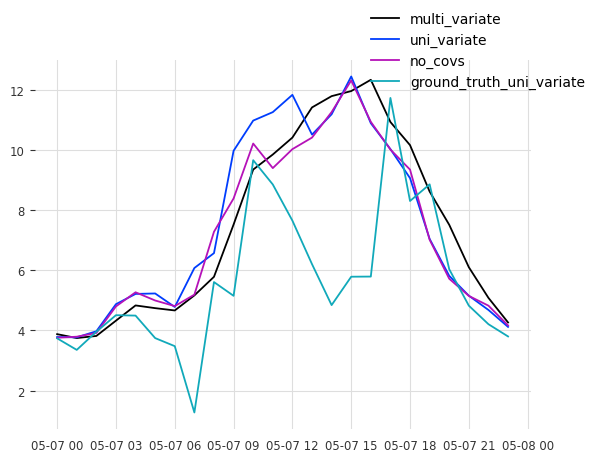

In [208]:
fig, ax = plt.subplots()

ax.plot(preds_1.mean(axis=1).to_frame('multi_variate'), label='multi_variate')
ax.plot(preds_2.mean(axis=1).to_frame('uni_variate'), label='uni_variate')
ax.plot(preds_3.mean(axis=1).to_frame('direct'), label='no_covs')
ax.plot(ts_2[(idx+1)][-48:-24].pd_dataframe(), label='ground_truth_uni_variate')

fig.legend()


## Wandb Transformer Tuning

In [ ]:
from darts.models import TFTModel
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau


def train_tft():


    config_ = build_config(config_run)

    wandb.init()
    config = wandb.config
    config.update(config_.data)

    print('config updated')
    model_setups_data = load_data(config)
    piped_data, pipeline = darts_data_pipeline(config, model_setups_data)
    ts_train_piped, ts_val_piped, ts_test_piped = piped_data['target']
    ts_cov_train_piped, ts_cov_val_piped, ts_cov_test_piped = piped_data['covs']
    trg_train_inversed, trg_val_inversed, trg_test_inversed = piped_data['target_inversed']


    optimizer_kwargs = {}
    try:
        optimizer_kwargs['lr'] = config.lr
    except:
        optimizer_kwargs['lr'] = 1e-3

    pl_trainer_kwargs = {
    'max_epochs': 20,
    'accelerator': 'gpu',
    'devices': [0],
    'callbacks': [EarlyStopping(monitor='val_loss', patience=5, mode='min')],
    'logger': WandbLogger(log_model='best'),
    }

    lr_scheduler_kwargs = {
        'patience': 2,
        'factor': 0.5,
        'min_lr': 1e-5,
        'verbose': True
        }


    model = TFTModel(
    input_chunk_length=config.n_lags,
    output_chunk_length=config.n_ahead,
    hidden_size=config.hidden_size,
    batch_size=config.batch_size,
    lr_scheduler_cls = ReduceLROnPlateau,
    lr_scheduler_kwargs = lr_scheduler_kwargs,
    optimizer_kwargs = optimizer_kwargs,
    pl_trainer_kwargs = pl_trainer_kwargs)
    
    model.fit(ts_train_piped, future_covariates = ts_cov_train_piped, val_series=ts_val_piped, val_future_covariates =ts_cov_val_piped)

    print('Evaluating on validation set')
    df_predictions, scores = predict_testset(config, model, 
                                    ts_val_piped, 
                                    ts_cov_val_piped,
                                    pipeline,
                                    )

    df_predictions.columns = ['prediction_'+config.model_setup]

    df_compare = pd.merge(trg_val_inversed.pd_dataframe(), df_predictions, left_index=True, right_index=True, how = 'left')
    fig = px.line(df_compare)


    wandb.log({'fig': fig})
    wandb.log({'val_rmse': scores['rmse']})
    wandb.finish()

In [ ]:
train_tft()

### Testing

In [ ]:


model_setups_names = ['integrated',
                        'additive',
                        'direct'
                      ]

config_run = {
'model_setup': 'integrated',
'METER': '1',
'META': '1',
'train_ratio': 0.2,
'val_ratio' : 0.1,
'lookback_in_hours' : 24,
'liklihood': None,
'holiday': True,
'use_datetime_encoding': False,
'boxcox': False,
#'eval_metrics' : [mae, mse, rmse],
'evaluation_set': 'val'
}

eval_set_idx = {'train': 0, 'val': 1, 'test': 2}




sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'model_setup': {
            'values': ['integrated']
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'lr': {
            'values': [3e-4, 1e-3, 1e-4, 1e-5]
        },
        'full_attention': {
            'values': [True, False]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'num_attention_heads': {
            'values': [3,4,5,6]
        },
        'hidden_size': {
            'values': [512, 1024, 2048]
        }
    }
}



sweep_id = wandb.sweep(sweep_config, project="net-load-forecasting")

wandb.agent(sweep_id, function=train_tft, count=1)

        

